In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Goal
Given the large number of literature and the rapid spread of COVID-19, it is difficult for health professionals to keep up with new information on the virus. Can clustering similar research articles together simplify the search for related publications? How can the content of the clusters be qualified?

By using clustering for labelling in combination with dimensionality reduction for visualization, the collection of literature can be represented by a scatter plot. On this plot, publications of highly similar topic will share a label and will be plotted near each other. In order, to find meaning in the clusters, topic modelling will be performed to find the keywords of each cluster.

By using Bokeh, the plot will be interactive. User’s will have the option of seeing the plot as a whole or filtering the data by cluster. If a narrower scope is required, the plot will also have a search function which will limit the output to only papers containing the search term. Hovering over points on the plot will give basic information like title, author, journal, and abstract. Clicking on a point will bring up a menu with a URL that can be used to access the full publication.

This is a difficult time in which health care workers, sanitation staff, and many other essential personnel are out there keeping the world afloat. While adhering to quarantine protocol, the Kaggle CORD-19 competition has given us an opportunity to help in the best way we can as computer science students. It should be noted, however, that we are not epidemiologists, and it is not our place to gauge the importance of these papers. This tool was created to help make it easier for trained professionals to sift through many, many publications related to the virus, and find their own determinations.

# Approach:

- Parse the text from the body of each document using Natural Language Processing (NLP).
- Turn each document instance $d_i$ into a feature vector $X_i$ using Term Frequency–inverse Document Frequency (TF-IDF).
- Apply Dimensionality Reduction to each feature vector $X_i$ using t-Distributed Stochastic Neighbor Embedding (t-SNE) to cluster similar research articles in the two dimensional plane $X$ embedding $Y_1$.
- Use Principal Component Analysis (PCA) to project down the dimensions of $X$ to a number of dimensions that will keep .95 variance while removing noise and outliers in embedding $Y_2$.
- Apply k-means clustering on $Y_2$, where $k$ is 20, to label each cluster on $Y_1$.
- Apply Topic Modeling on $X$ using Latent Dirichlet Allocation (LDA) to discover keywords from each cluster. 
- Investigate the clusters visually on the plot, zooming down to specific articles as needed, and via classification using Stochastic Gradient Descent (SGD). 

<br>

# Dataset Description
In response to the COVID-19 pandemic, the White House and a coalition of leading research groups have prepared the COVID-19 Open Research Dataset (CORD-19). CORD-19 is a resource of over 51,000 scholarly articles, including over 40,000 with full text, about COVID-19, SARS-CoV-2, and related coronaviruses. This freely available dataset is provided to the global research community to apply recent advances in natural language processing and other AI techniques to generate new insights in support of the ongoing fight against this infectious disease. There is a growing urgency for these approaches because of the rapid acceleration in new coronavirus literature, making it difficult for the medical research community to keep up.

Cite: COVID-19 Open Research Dataset Challenge (CORD-19) | Kaggle
Kaggle Submission: COVID-19 Literature Clustering | Kaggle

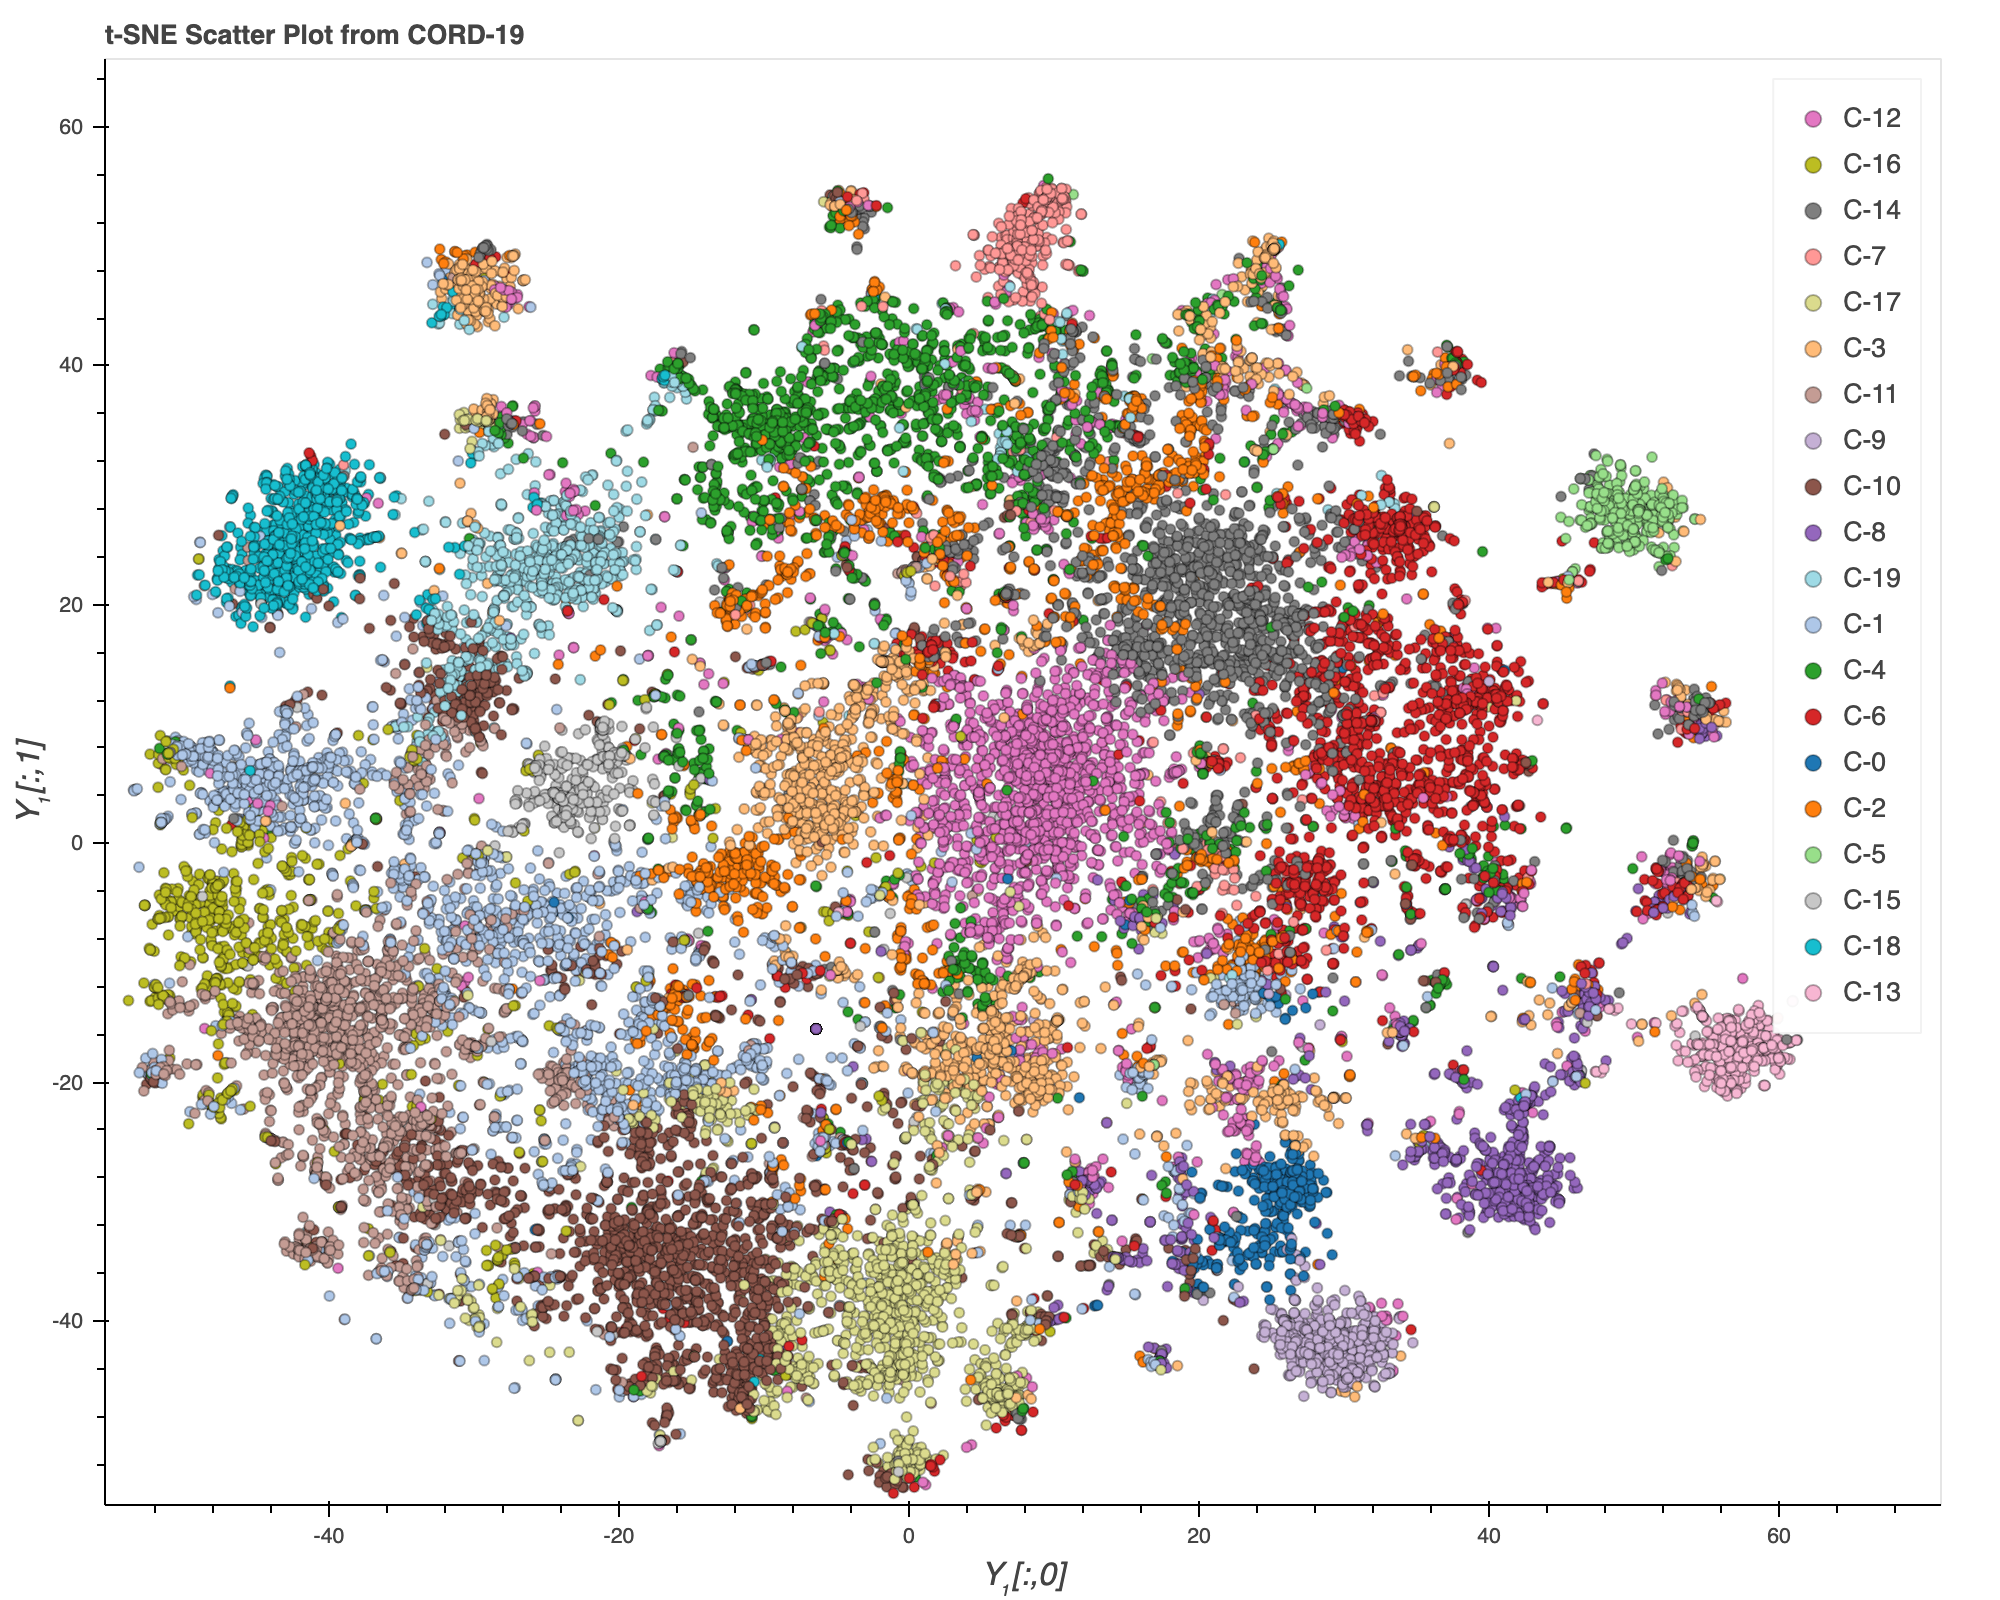

In [3]:
from IPython.display import Image
Image(filename='/kaggle/input/kaggle-resources/bokeh_plot.png', width=800, height=800)

# Loading the Data

In [4]:
import glob
import json
import matplotlib.pyplot as plt

plt.style.use('ggplot')

Let's load the metadata of the dateset. 'title' and 'journal' attributes may be useful later when we cluster the articles to see what kinds of articles cluster together.

In [5]:
root_path = '/kaggle/input/CORD-19-research-challenge/'
metadata_path = f'{root_path}/metadata.csv'
meta_df = pd.read_csv(metadata_path, dtype = 
                      {'pubmed_id' : str, 
                       'Microsoft Academic Paper ID': str, 
                       'doi': str})
meta_df.head()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (1,5,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


cord_uid                                       sha source_x  \
0  ug7v899j  d1aafb70c066a2068b02786f8929fd9c900897fb      PMC   
1  02tnwd4m  6b0567729c2143a66d737eb0a2f63f2dce2e5a7d      PMC   
2  ejv2xln0  06ced00a5fc04215949aa72528f2eeaae1d58927      PMC   
3  2b73a28n  348055649b6b8cf2b9a376498df9bf41f7123605      PMC   
4  9785vg6d  5f48792a5fa08bed9f56016f4981ae2ca6031b32      PMC   

                                               title                    doi  \
0  Clinical features of culture-proven Mycoplasma...  10.1186/1471-2334-1-6   
1  Nitric oxide: a pro-inflammatory mediator in l...           10.1186/rr14   
2    Surfactant protein-D and pulmonary host defense           10.1186/rr19   
3               Role of endothelin-1 in lung disease           10.1186/rr44   
4  Gene expression in epithelial cells in respons...           10.1186/rr61   

      pmcid pubmed_id license  \
0  PMC35282  11472636   no-cc   
1  PMC59543  11667967   no-cc   
2  PMC59549  11667972   no-cc   
3  PMC59574  11686871   no-cc   
4  PMC59580  11686888   no-cc   

                                            abstract publish_time  \
0  OBJECTIVE: This retrospective chart review des...   2001-07-04   
1  Inflammatory diseases of the respiratory tract...   2000-08-15   
2  Surfactant protein-D (SP-D) participates in th...   2000-08-25   
3  Endothelin-1 (ET-1) is a 21 amino acid peptide...   2001-02-22   
4  Respiratory syncytial virus (RSV) and pneumoni...   2001-05-11   

                                             authors         journal  mag_id  \
0                Madani, Tariq A; Al-Ghamdi, Aisha A  BMC Infect Dis     NaN   
1  Vliet, Albert van der; Eiserich, Jason P; Cros...      Respir Res     NaN   
2                                    Crouch, Erika C      Respir Res     NaN   
3  Fagan, Karen A; McMurtry, Ivan F; Rodman, David M      Respir Res     NaN   
4  Domachowske, Joseph B; Bonville, Cynthia A; Ro...      Respir Res     NaN   

  who_covidence_id arxiv_id  \
0              NaN      NaN   
1              NaN      NaN   
2              NaN      NaN   
3              NaN      NaN   
4              NaN      NaN   

                                      pdf_json_files  \
0  document_parses/pdf_json/d1aafb70c066a2068b027...   
1  document_parses/pdf_json/6b0567729c2143a66d737...   
2  document_parses/pdf_json/06ced00a5fc04215949aa...   
3  document_parses/pdf_json/348055649b6b8cf2b9a37...   
4  document_parses/pdf_json/5f48792a5fa08bed9f560...   

                               pmc_json_files  \
0  document_parses/pmc_json/PMC35282.xml.json   
1  document_parses/pmc_json/PMC59543.xml.json   
2  document_parses/pmc_json/PMC59549.xml.json   
3  document_parses/pmc_json/PMC59574.xml.json   
4  document_parses/pmc_json/PMC59580.xml.json   

                                                 url  s2_id  
0  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...    NaN  
1  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
2  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
3  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
4  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN

In [ ]:
meta_df.info()

Fetch All of JSON File Path

In [6]:
all_json = glob.glob(f'{root_path}/**/*.json', recursive = True)
len(all_json)

156353

# Helper Functions

 File Reader Class

In [7]:
class FileReader:
    def __init__(self, file_path):
        with open(file_path) as file:
            content = json.load(file)
            self.paper_id = content['paper_id']
            self.abstract = []
            self.body_text = []
            
            if 'abstract' in content.keys():
                for entry in content['abstract']:                
                    self.abstract.append(entry['text'])
            
            if 'body_text' in content.keys():
                for entry in content['body_text']:
                    self.body_text.append(entry['text'])
                
            self.abstract = '\n'.join(self.abstract)
            self.body_text = '\n'.join(self.body_text)
            
    def __repr__(self):
        return f'{self.paper_id}:{self.abstract[:200]}... {self.body_text[:200]}...'
first_row = FileReader(all_json[200])
print(first_row)

PMC6587251:... Similarity analysis of protein sequences plays an important role in protein sequence studies, e.g. the prediction or classification of protein structures and functions. In General, the biological func...


Helper function adds break after every words when character length reach to certain amount. This is for the interactive plot so that hover tool fits the screen.

In [8]:
def get_breaks(content, length):
    data = ""
    words = content.split(' ')
    total_chars = 0
    for i in range(len(words)):
        total_chars += len(words[i])
        if total_chars > length:
            data = data + "<br>" + words[i]
            total_chars = 0 
        else:
            data = data + " "+ words[i]
        return data

# Load the Data into DataFrame

Using the helper functions, let's read in the articles into a DataFrame that can be used easily:

In [9]:
from random import sample
dict_ = {'paper_id': [], 'doi':[], 'abstract': [], 'body_text': [], 'authors': [], 'title': [], 'journal': [], 'abstract_summary': []}
for idx, entry in enumerate(sample(all_json,10000)):
    if idx > 10000:
        break
    if idx % (len(all_json) // 10) == 0:
        print(f'Processing index: {idx} of {len(all_json)}')
    
    try:
        content = FileReader(entry)
    except Exception as e:
        continue  # invalid paper format, skip
    
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    # no metadata, skip this paper
    if len(meta_data) == 0:
        continue
    
    dict_['abstract'].append(content.abstract)
    dict_['paper_id'].append(content.paper_id)
    dict_['body_text'].append(content.body_text)
    
    # also create a column for the summary of abstract to be used in a plot
    if len(content.abstract) == 0: 
        # no abstract provided
        dict_['abstract_summary'].append("Not provided.")
    elif len(content.abstract.split(' ')) > 100:
        # abstract provided is too long for plot, take first 100 words append with ...
        info = content.abstract.split(' ')[:100]
        summary = get_breaks(' '.join(info), 40)
        dict_['abstract_summary'].append(summary + "...")
    else:
        # abstract is short enough
        summary = get_breaks(content.abstract, 40)
        dict_['abstract_summary'].append(summary)
        
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    
    try:
        # if more than one author
        authors = meta_data['authors'].values[0].split(';')
        if len(authors) > 2:
            # if more than 2 authors, take them all with html tag breaks in between
            dict_['authors'].append(get_breaks('. '.join(authors), 40))
        else:
            # authors will fit in plot
            dict_['authors'].append(". ".join(authors))
    except Exception as e:
        # if only one author - or Null valie
        dict_['authors'].append(meta_data['authors'].values[0])
    
    # add the title information, add breaks when needed
    try:
        title = get_breaks(meta_data['title'].values[0], 40)
        dict_['title'].append(title)
    # if title was not provided
    except Exception as e:
        dict_['title'].append(meta_data['title'].values[0])
    
    # add the journal information
    dict_['journal'].append(meta_data['journal'].values[0])
    
    # add doi
    dict_['doi'].append(meta_data['doi'].values[0])
    
df_covid = pd.DataFrame(dict_, columns=['paper_id', 'doi', 'abstract', 'body_text', 'authors', 'title', 'journal', 'abstract_summary'])
df_covid.head()
        

Processing index: 0 of 156353


paper_id  \
0  dc91060cc17148ba08aff6c6e9c58d06748fb15a   
1  7151f81089f1888d76921ec172674ecd092bf923   
2  c9e9e8c5a380de1628387cea9af954a3a0a947df   
3  419a938878e05cb44860b9592a8d72d3e415f613   
4  ce2184a9344e5a044a8e307ec161cfd454b258e0   

                                  doi  \
0                10.1017/dmp.2020.188   
1           10.1007/s11524-007-9234-y   
2  10.1016/j.diagmicrobio.2019.01.007   
3                 10.1093/cid/ciaa423   
4        10.1371/journal.pntd.0006275   

                                            abstract  \
0                                                      
1  Internationally, youth violence is becoming an...   
2  Introduction: This study compares the detectio...   
3  Background: Evaluating whether an infectious d...   
4                                                      

                                           body_text         authors  \
0  I n December 2019, the pneumonia epidemic that...  Özyer, Yasemin   
1  Deena J. Chisolm PhD; William Garnder PhD; Jac...             NaN   
2  Acute respiratory infections (ARI) are one of ...         Kenmoe,   
3  A c c e p t e d M a n u s c r i p t China. The...        Weiming,   
4  through the Project Bioshield Act of 2004 [8] ...       Espeland,   

           title                                           journal  \
0           2019  Disaster medicine and public health preparedness   
1        Section                                    J Urban Health   
2     Comparison    Diagnostic Microbiology and Infectious Disease   
3            The                                   Clin Infect Dis   
4   Safeguarding                                PLoS Negl Trop Dis   

       abstract_summary  
0         Not provided.  
1   Internationally,...  
2      Introduction:...  
3           Background:  
4         Not provided.

## Some feature engineering
Adding word count columns for both abstract and body_text can be useful parameters later:

In [10]:
df_covid['abstract_word_count'] = df_covid['abstract'].apply(lambda x: len(x.strip().split()))  # word count in abstract
df_covid['body_word_count'] = df_covid['body_text'].apply(lambda x: len(x.strip().split()))  # word count in body
df_covid['body_unique_words']=df_covid['body_text'].apply(lambda x:len(set(str(x).split())))  # number of unique words in body
df_covid.head()

paper_id  \
0  dc91060cc17148ba08aff6c6e9c58d06748fb15a   
1  7151f81089f1888d76921ec172674ecd092bf923   
2  c9e9e8c5a380de1628387cea9af954a3a0a947df   
3  419a938878e05cb44860b9592a8d72d3e415f613   
4  ce2184a9344e5a044a8e307ec161cfd454b258e0   

                                  doi  \
0                10.1017/dmp.2020.188   
1           10.1007/s11524-007-9234-y   
2  10.1016/j.diagmicrobio.2019.01.007   
3                 10.1093/cid/ciaa423   
4        10.1371/journal.pntd.0006275   

                                            abstract  \
0                                                      
1  Internationally, youth violence is becoming an...   
2  Introduction: This study compares the detectio...   
3  Background: Evaluating whether an infectious d...   
4                                                      

                                           body_text         authors  \
0  I n December 2019, the pneumonia epidemic that...  Özyer, Yasemin   
1  Deena J. Chisolm PhD; William Garnder PhD; Jac...             NaN   
2  Acute respiratory infections (ARI) are one of ...         Kenmoe,   
3  A c c e p t e d M a n u s c r i p t China. The...        Weiming,   
4  through the Project Bioshield Act of 2004 [8] ...       Espeland,   

           title                                           journal  \
0           2019  Disaster medicine and public health preparedness   
1        Section                                    J Urban Health   
2     Comparison    Diagnostic Microbiology and Infectious Disease   
3            The                                   Clin Infect Dis   
4   Safeguarding                                PLoS Negl Trop Dis   

       abstract_summary  abstract_word_count  body_word_count  \
0         Not provided.                    0              971   
1   Internationally,...                  844            41064   
2      Introduction:...                  151             3603   
3           Background:                   93             2290   
4         Not provided.                    0             1019   

   body_unique_words  
0                456  
1               9764  
2               1145  
3                826  
4                481

In [ ]:
df_covid.info()

In [ ]:
df_covid['abstract'].describe(include='all')

# Handle Possible Duplicates

When we look at the unique values above, we can see that tehre are duplicates. It may have caused because of author submiting the article to multiple journals. Let's remove the duplicats from our dataset:

In [11]:
df_covid.drop_duplicates(['abstract','body_text'], inplace = True)
df_covid['abstract'].describe(include = 'all')

count     5156
unique    3547
top           
freq      1604
Name: abstract, dtype: object

In [ ]:
df_covid['abstract'].describe(include = 'all')

It looks like we didn't have duplicates. Instead, it was articles without Abstracts.

In [ ]:
df_covid.head()

In the majority of this notebook we will be working with **body_text** <br>
Links to the papers will be generated using **doi** 

In [ ]:
df_covid.describe()

# Data Pre-processing

Unfortunately, running the next steps of the notebook is not possible on the full dataset within Kaggle.
In Kaggle we will limit the dataframe to **10,000** instances

Now that we have our dataset loaded, we need to clean-up the text to improve any clustering or classification efforts. First, let's drop Null vales:

In [13]:
df_covid.dropna(inplace = True)

In [14]:
pip install langdetect

     |████████████████████████████████| 981 kB 2.8 MB/s eta 0:00:01
  Created wheel for langdetect: filename=langdetect-1.0.8-py3-none-any.whl size=993191 sha256=b4a28d44c3d338f8fd9b7a76ac9436fa6f649bae425f391f0c9cf01d96433895
  Stored in directory: /root/.cache/pip/wheels/59/f6/9d/85068904dba861c0b9af74e286265a08da438748ee5ae56067
Successfully built langdetect
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [15]:
from tqdm import tqdm
from langdetect import detect
from langdetect import DetectorFactory

# set seed
DetectorFactory.seed = 0

# hold label - language
languages = []

# go through each text
for ii in tqdm(range(0,len(df_covid))):
    # split by space into list, take the first x intex, join with space
    text = df_covid.iloc[ii]['body_text'].split(" ")
    
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    # ught... beginning of the document was not in a good format
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        # what!! :( let's see if we can find any text in abstract...
        except Exception as e:
            
            try:
                # let's try to label it through the abstract then
                lang = detect(df.iloc[ii]['abstract_summary'])
            except Exception as e:
                lang = "unknown"
                pass
    
    # get the language    
    languages.append(lang)

100%|██████████| 4615/4615 [00:58<00:00, 79.42it/s]


In [16]:
from pprint import pprint
languages_dict = {}
for lang in set(languages):
    languages_dict[lang]= languages.count(lang)
    
print("Total: {}\n".format(len(languages)))
pprint(languages_dict)

Total: 4615

{'cy': 2,
 'de': 57,
 'en': 4462,
 'es': 39,
 'fr': 43,
 'id': 1,
 'it': 1,
 'nl': 5,
 'pl': 1,
 'pt': 2,
 'sv': 1,
 'zh-cn': 1}


Lets take a look at the language distribution in the dataset

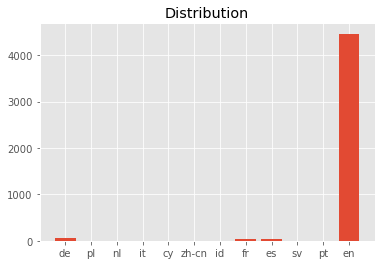

In [17]:
df_covid['language'] = languages
plt.bar(range(len(languages_dict)), list(languages_dict.values()), align = 'center')
plt.xticks(range(len(languages_dict)), list(languages_dict.keys()))
plt.title('Distribution')
plt.show()


We will be dropping any language that is not English. Attempting to translate foreign texts gave the following problems:

1. API calls were limited

2. Translating the language may not carry over the true semantic meaning of the text

In [18]:
df = df_covid[df_covid['language'] == 'en']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4462 entries, 0 to 5159
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   paper_id             4462 non-null   object
 1   doi                  4462 non-null   object
 2   abstract             4462 non-null   object
 3   body_text            4462 non-null   object
 4   authors              4462 non-null   object
 5   title                4462 non-null   object
 6   journal              4462 non-null   object
 7   abstract_summary     4462 non-null   object
 8   abstract_word_count  4462 non-null   int64 
 9   body_word_count      4462 non-null   int64 
 10  body_unique_words    4462 non-null   int64 
 11  language             4462 non-null   object
dtypes: int64(3), object(9)
memory usage: 453.2+ KB


In [19]:
# Download the spacy bio parser
from IPython.utils import io
with io.capture_output() as captured:
    !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz

In [20]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_sci_lg

### Stopwords

Part of the preprocessing will be finding and removing stopwords (common words that will act as noise in the clustering step).

In [21]:
import string

punctuations = string.punctuation
stopwords = list(STOP_WORDS)
stopwords[:10]

['toward',
 'do',
 're',
 'before',
 'done',
 'various',
 'why',
 'yourself',
 'five',
 'only']

Now the above stopwords are used in everyday english text. Research papers will often frequently use words that don't actually contribute to the meaning and are not considered everyday stopwords.

In [22]:
custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
    'al.', 'Elsevier', 'PMC', 'CZI', 'www'
]

for w in custom_stop_words:
    if w not in stopwords:
        stopwords.append(w)

### Next lets create a function that will process the text data for us. 
For this purpose we will be using the spacy library. This function will convert text to lower case, remove punctuation, and find and remove stopwords. For the parser, we will use en_core_sci_lg. This is a model for processing biomedical, scientific or clinical text.

In [23]:
parser = en_core_sci_lg.load(disable = ["tagger", "ner"])
parser.max_length = 7000000

def spacy_tokenizer(sentence):
    my_tokens = parser(sentence)
    my_tokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in my_tokens]
    my_tokens = [word for word in my_tokens if word not in stopwords and word not in punctuations]
    my_tokens = " ".join([ i for i in my_tokens])
    return my_tokens

Applying the text-processing function on the **body_text**. 

In [25]:
tqdm.pandas()
#df["processed_text"] = df["body_text"].progress_apply(spacy_tokenizer)

### Let's take a look at word count in the papers

count     4462.000000
mean      3580.350067
std       3503.426891
min          3.000000
25%       1509.250000
50%       3000.500000
75%       4588.750000
max      76612.000000
Name: body_word_count, dtype: float64

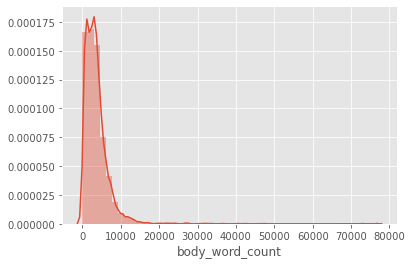

In [26]:
import seaborn as sns
sns.distplot(df['body_word_count'])
df['body_word_count'].describe()

count     4462.000000
mean      1170.162931
std        779.772576
min          3.000000
25%        657.000000
50%       1071.000000
75%       1481.750000
max      12937.000000
Name: body_unique_words, dtype: float64

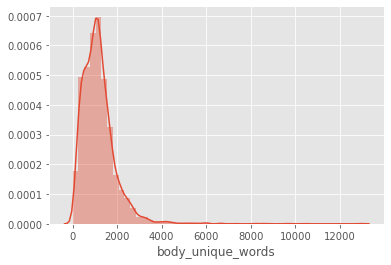

In [27]:
sns.distplot(df['body_unique_words'])
df['body_unique_words'].describe()

These two plots give us a good idea of the content we are dealing with. Most papers are about 5000 words in length. The long tails in both plots are caused by outliers. In fact, ~98% of the papers are under 20,000 words in length while a select few are over 200,000!

In [28]:
!conda install -y gdown
!gdown "https://drive.google.com/uc?id=134h9QB4V9h1XjFqPs_cVfvpR5qr1vZqO"

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdown


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    certifi-2020.6.20          |   py37hc8dfbb8_0         151 KB  conda-forge
    gdown-3.12.0               |     pyh9f0ad1d_0          12 KB  conda-forge
    openssl-1.1.1g             |       h516909a_1         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.4 MB

The following NEW packages will be INSTALLED:

  gdown              conda-forge/noarch::gdown-3.12.0-pyh9f0ad1d_0

The following packages will be UPDATED:

  ca-certificates                     2020.4.5.1-hecc5488_0 --> 2020.6.20-hecda079_0
  certifi                         2020.4.5.1-py37h

In [29]:
!mv '/kaggle/working/processed_text' '/kaggle/working/processed_text.csv'

In [30]:
df_temp = pd.read_csv("/kaggle/working/processed_text.csv", index_col = False)


In [31]:
df['processed_text'] = df_temp['processed_text']


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# Vectorization

Now that we have pre-processed the data, it is time to convert it into a format that can be handled by our algorithms. For this purpose we will be using tf-idf. This will convert our string formatted data into a measure of how important each word is to the instance out of the literature as a whole.

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(text, maxx_features):
    vectorizer = TfidfVectorizer(max_features = maxx_features)
    X = vectorizer.fit_transform(text)
    return X

In [33]:
df.dropna(inplace = True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Vectorize our data. We will be clustering based off the content of the body text. The maximum number of features will be limited. Only the top 2 ** 12 features will be used, eseentially acting as a noise filter. Additionally, more features cause painfully long runtimes.

In [34]:

text = df["processed_text"].values
X = vectorize(text, 2**12)
X.shape    

(3775, 4096)

# PCA  & Clustering

Let's see how much we can reduce the dimensions while still keeping 95% variance. We will apply Principle Component Analysis (PCA) to our vectorized data. The reason for this is that by keeping a large number of dimensions with PCA, you don’t destroy much of the information, but hopefully will remove some noise/outliers from the data, and make the clustering problem easier for k-means. Note that X_reduced will only be used for k-means, t-SNE will still use the original feature vector X that was generated through tf-idf on the NLP processed text.

In [35]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95, random_state =42)
X_reduced = pca.fit_transform(X.toarray())
X_reduced.shape

(3775, 1710)

To separate the literature, k-means will be run on the vectorized text. Given the number of clusters, k, k-means will categorize each vector by taking the mean distance to a randomly initialized centroid. The centroids are updated iteratively.

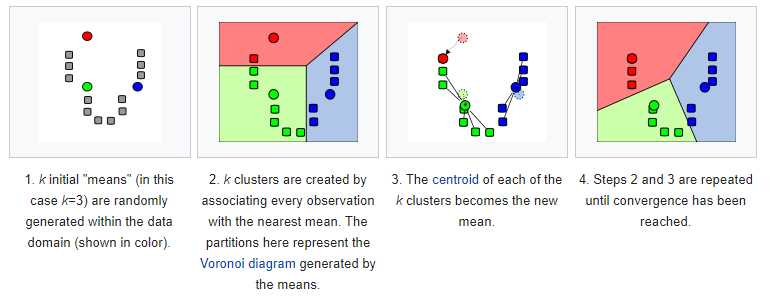

In [36]:
from sklearn.cluster import KMeans
Image(filename = '/kaggle/input/kaggle-resources/kmeans.PNG', width = 800,height = 800)

### How many clusters? 

To find the best k value for k-means we'll look at the distortion at different k values. Distortion computes the sum of squared distances from each point to its assigned center. When distortion is plotted against k there will be a k value after which decreases in distortion are minimal. This is the desired number of clusters.

In [37]:
from sklearn import metrics
from scipy.spatial.distance import cdist

distortions = []
K = range(2,50)
for k in K:
    k_means = KMeans(n_clusters = k, random_state= 42)
    k_means.fit(X_reduced)
    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis = 1)) / X.shape[0])

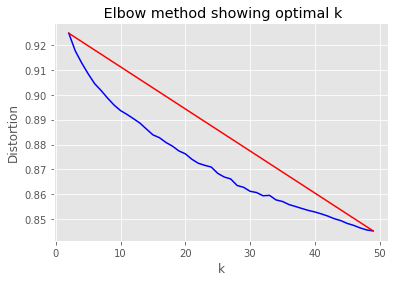

In [38]:
X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title(' Elbow method showing optimal k')
plt.show()

In this plot we can see that the better k values are between 18-25. After that, the decrease in distortion is not as significant. For simplicity, we will use k=20

### Run k-means

Now that we have an appropriate k value, we can run k-means on the PCA-processed feature vector (X_reduced). 

In [39]:
k = 20
kmeans = KMeans(n_clusters = k, random_state = 42 )
y_pred = kmeans.fit_predict(X_reduced)
df["y"] = y_pred

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
!conda install -y gdown
!gdown "https://drive.google.com/uc?id=1B-x7wqlsYLf7i34G0Rfiu38yo337KBTT"

In [40]:
!gdown "https://drive.google.com/uc?id=1B-x7wqlsYLf7i34G0Rfiu38yo337KBTT"

Downloading...
From: https://drive.google.com/uc?id=1B-x7wqlsYLf7i34G0Rfiu38yo337KBTT
To: /kaggle/working/processed_data.csv
167MB [00:03, 49.4MB/s] 


In [41]:
new_df = pd.read_csv("./processed_data.csv", index_col = False)

In [42]:
df = new_df.drop(['Unnamed: 0'],axis=1)

# Dimensionality Reduction with t-SNE

Using [t-SNE](https://lvdmaaten.github.io/tsne) we can reduce our high dimensional features vector to 2 dimensions. By using the 2 dimensions as x,y coordinates, the body_text can be plotted. 

> t-Distributed Stochastic Neighbor Embedding (t-SNE) reduces dimensionality while trying to keep similar instances close and dissimilar instances apart. It is mostly used for visualization, in particular to visualize clusters of instances in high-dimensional space

In [43]:
from sklearn.manifold import TSNE
tsne = TSNE(verbose = 1, perplexity = 100, random_state = 42)
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 3775 samples in 2.109s...
[t-SNE] Computed neighbors for 3775 samples in 137.431s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3775
[t-SNE] Computed conditional probabilities for sample 2000 / 3775
[t-SNE] Computed conditional probabilities for sample 3000 / 3775
[t-SNE] Computed conditional probabilities for sample 3775 / 3775
[t-SNE] Mean sigma: 0.365341
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.541229
[t-SNE] KL divergence after 1000 iterations: 1.587965


So that step took a while! Let's take a look at what our data looks like when compressed to 2 dimensions. 

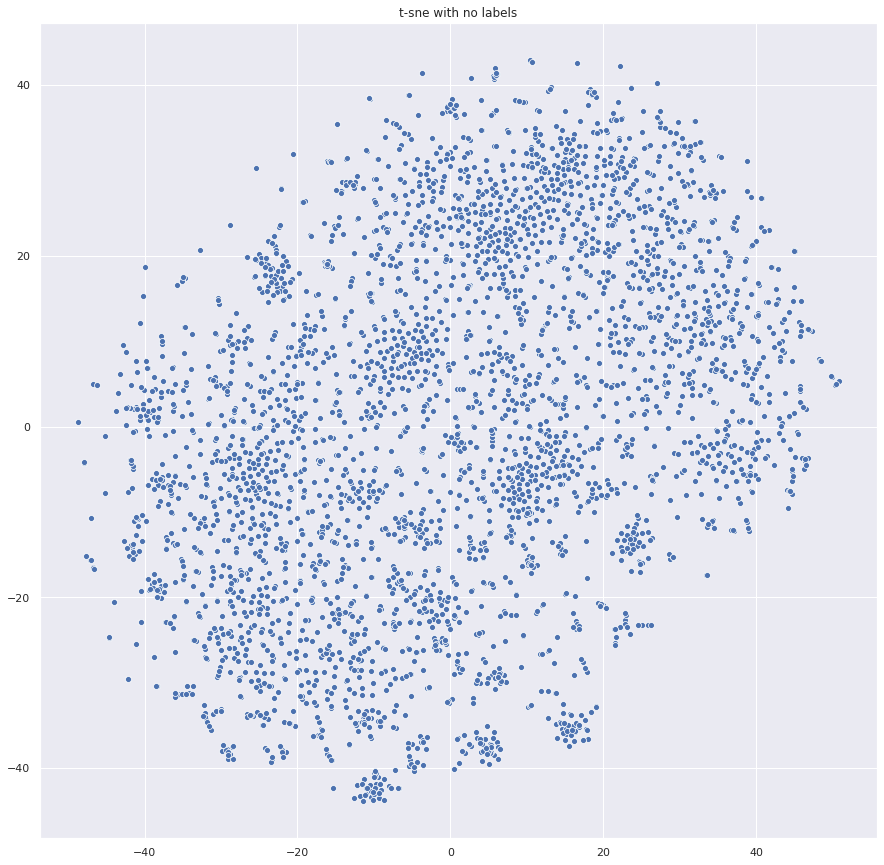

In [44]:
from matplotlib import pyplot as plt
import seaborn as sns

sns.set(rc= {'figure.figsize':(15,15)})
palette = sns.color_palette("bright",1)

sns.scatterplot(X_embedded[:,0],X_embedded[:,1], palette = palette)
plt.title("t-sne with no labels")
plt.savefig("t-sne covid-19.png")
plt.show()

This looks pretty bland. There are some clusters we can immediately detect, but the many instances closer to the center are harder to separate. t-SNE did a good job at reducing the dimensionality, but now we need some labels. Let's use the clusters found by k-means as labels. This will help visually separate different concentrations of topics.

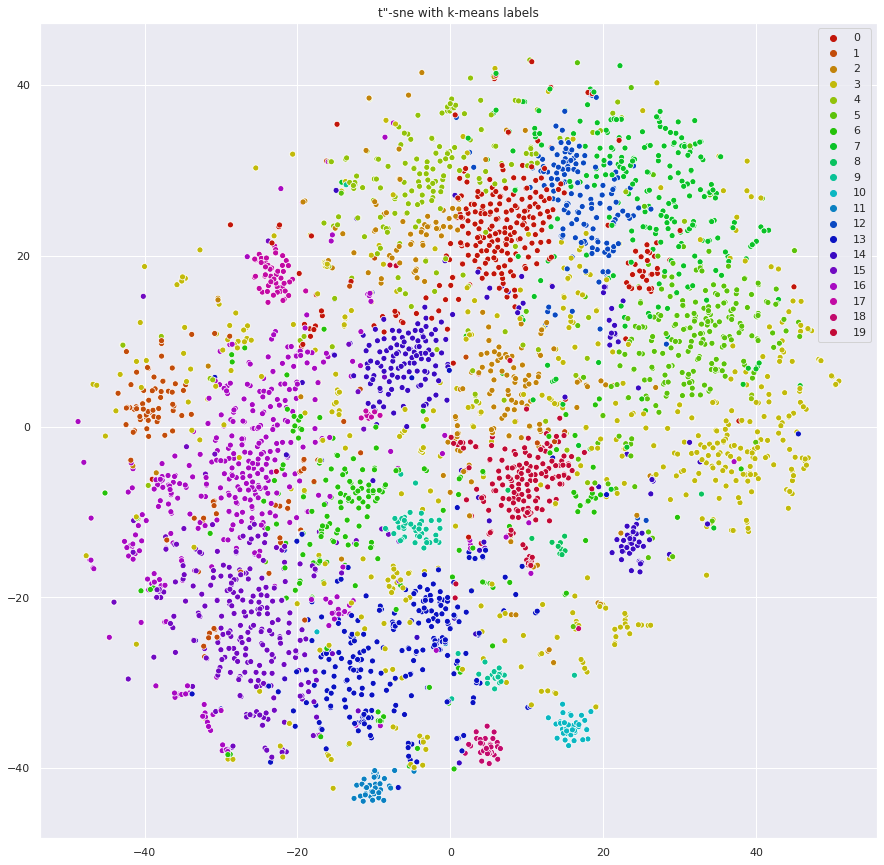

In [45]:
%matplotlib inline
import seaborn as sns
sns.set(rc= {'figure.figsize':(15,15)})
palette = sns.hls_palette(20, l=.4,s=.9)

sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue = y_pred, legend = "full", palette = palette)
plt.title('t"-sne with k-means labels')
plt.savefig("improved_cluster_tsne")
plt.show()

The labeled plot gives better insight into how the papers are grouped. It is interesting that both k-means and t-SNE are able to agree on certain clusters even though they were ran independetly. The location of each paper on the plot was determined by t-SNE while the label (color) was determined by k-means. If we look at a particular part of the plot where t-SNE has grouped many articles forming a cluster, it is likely that k-means is uniform in the labeling of this cluster (most of the cluster is the same color). This behavior shows that structure within the literature can be observed and measured to some extent. 

Now there are other cases where the colored labels (k-means) are spread out on the plot (t-SNE). This is a result of t-SNE and k-means finding different connections in the higher dimensional data. The topics of these papers often intersect so it hard to cleanly separate them. This effect can be observed in the formation of subclusters on the plot. These subclusters are a conglomeration of different k-means labels but may share some connection determined by t-SNE.

This organization of the data does not act as a simple search engine. The clustering + dimensionality reduction is performed on the mathematical similarities of the publications. As an unsupervised approach, the algorithms may even find connections that were unnaparent to humans. This may highlight hidden shared information and advance further research.

# Topic Modeling on Each Cluster

Now we will attempt to find the most significant words in each clusters. K-means clustered the articles but did not label the topics. Through topic modeling we will find out what the most important terms for each cluster are. This will add more meaning to the cluster by giving keywords to quickly identify the themes of the cluster.

For topic modeling, we will use LDA (Latent Dirichlet Allocation). In LDA, each document can be described by a distribution of topics and each topic can be described by a distribution of words[.]

In [46]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

First we will create 20 vectorizers, one for each of our cluster labels

In [47]:
vectorizers = []
for ii in range(0,20):
    vectorizers.append(CountVectorizer(min_df = 5, max_df=0.9, stop_words='english', lowercase = True, token_pattern = '[a-zA-Z\-][a-zA-Z\-]{2,}'))

In [ ]:
vectorizers[0]

Now we will vectorize the data from each of our clusters

In [48]:
vectorized_data = []

for cluster_no, cvec in enumerate(vectorizers):
    try:
        vectorized_data.append(cvec.fit_transform(df.loc[df['y']==cluster_no, 'processed_text']))
    except Exception as e:
        print("wrong no if instances")
        vectorized_data.append(None)
    

Topic modeling will be performed through the use of Latent Dirichlet Allocation (LDA). This is a generative statistical model that allows sets of words to be explained by a shared topic

In [49]:
Num_topics_per_cluster = 20

lda_models = []
for ii in range(0,20):
    lda = LatentDirichletAllocation(n_components = Num_topics_per_cluster, max_iter = 10, learning_method = 'online', verbose = False, random_state = 42 )
    lda_models.append(lda)
lda_models[0]

LatentDirichletAllocation(learning_method='online', n_components=20,
                          random_state=42, verbose=False)

For each cluster, we had created a correspoding LDA model in the previous step. We will now fit_transform all the LDA models on their respective cluster vectors

In [50]:
clusters_lda_data = []
for cluster_no, lda in enumerate(lda_models):
    if(vectorized_data[cluster_no] != None):
        clusters_lda_data.append(lda.fit_transform(vectorized_data[cluster_no]))
        

Extracts the keywords from each cluster

In [51]:
def selected_topics(model, vectorizer, top_n = 3):
    current_words = []
    keywords= []
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n-1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values

Append list of keywords for a single cluster to 2D list of length NUM_TOPICS_PER_CLUSTER

In [52]:
all_keywords = []
for current_vectorizer, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_vectorizer))

    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))

In [ ]:
all_keywords[0]

In [ ]:
len(all_keywords)

### Save current outputs to file

Re-running some parts of the notebook (especially vectorization and t-SNE) are time intensive tasks. We want to make sure that the important outputs for generating the bokeh plot are saved for future use.

In [53]:
os.getcwd()

'/kaggle/working'

In [54]:
os.chdir('/kaggle/working')

In [55]:
f=open('topics.txt','w')

count = 0

for ii in all_keywords:

    if vectorized_data[count] != None:
        f.write(', '.join(ii) + "\n")
    else:
        f.write("Not enough instances to be determined. \n")
        f.write(', '.join(ii) + "\n")
    count += 1

f.close()

In [ ]:
X_embedded

In [56]:
import pickle

# save the COVID-19 DataFrame, too large for github
pickle.dump(df, open("df_covid.p", "wb" ))

# save the final t-SNE
pickle.dump(X_embedded, open("X_embedded.p", "wb" ))

# save the labels generate with k-means(20)
pickle.dump(y_pred, open("y_pred.p", "wb" ))

# Classify

Though arbitrary, after running kmeans, the data is now 'labeled'. This means that we now use supervised learning to see how well the clustering generalizes. This is just one way to evaluate the clustering. If k-means was able to find a meaningful split in the data, it should be possible to train a classifier to predict which cluster a given instance should belong to. 

In [57]:
def classification_report(model_name,test,pred):
    from sklearn.metrics import precision_score, recall_score,accuracy_score,f1_score
    print(model_name,":\n")
    print("Accuracy score", '{:,.3f}'.format(float(accuracy_score(test,pred))*100),"%")
    print("Precision", '{:,.3f}'.format(float(precision_score(test,pred,average = 'macro'))*100), "%")
    print("Recall",'{:,.3f}'.format(float(recall_score(test,pred,average='macro'))*100),"%")
    print("      F1 score: ", '{:,.3f}'.format(float(f1_score(test, pred, average='macro')) * 100), "%")

In [58]:
text = df["processed_text"].values
X = vectorize(text, 2**12)
X.shape

(3762, 4096)

In [60]:
y_pred = df["y"]
y_pred.shape

(3762,)

Let's split the data into train/test sets

In [61]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X.toarray(), y_pred,test_size =0.2, random_state = 42)
print("xtrain size", len(x_train))
print("xtest size", len(x_test), "\n")

xtrain size 3009
xtest size 753 



**Precision** is ratio of True Positives to True Positives + False Positives. This is the accuracy of positive predictions<br>
**Recall** (also known as TPR) measures the ratio of True Positives to True Positives + False Negatives. It measures the ratio of positive instances that are correctly detected by the classifer.<br>
**F1 score**  is the harmonic average of the precision and recall. F1 score will only be high if both precision and recall are high


To test for overfitting, let's see how the model generalizes over the test set

In [62]:
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter = 10000, tol = 1e-3, random_state = 42, n_jobs=4)
sgd_pred = cross_val_predict(sgd_clf, x_train, y_train, cv=3, n_jobs=4)
classification_report("SGD report(training set)", y_train,sgd_pred)

SGD report(training set) :

Accuracy score 86.507 %
Precision 89.920 %
Recall 85.618 %
      F1 score:  87.356 %


In [63]:
sgd_clf.fit(x_train,y_train)
sgd_pred_test = sgd_clf.predict(x_test)
classification_report("SGD report(test)",y_test, sgd_pred_test )

SGD report(test) :

Accuracy score 88.712 %
Precision 90.295 %
Recall 90.504 %
      F1 score:  90.094 %


Now let's see how the model can generalize across the whole dataset.

In [64]:
sgd_cv_score = cross_val_score (sgd_clf, X.toarray(), y_pred, cv=10)
print("Mean score - SGD: {:,.3f}".format(float(sgd_cv_score.mean())*100),"%" )

Mean score - SGD: 88.357 %


# Plotting the data
The previous steps have given us clustering labels and a dataset of papers reduced to two dimensions. By pairing this with Bokeh, we can create an interactive plot of the literature. This should organize the papers such that related publications are in close proximity. To try to undertstand what the similarities may be, we have also performed topic modelling on each cluster of papers in order to pick out the key terms.

Bokeh will pair the actual papers with their positions on the t-SNE plot. Through this approach it will be easier to see how papers fit together, allowing for both exploration of the dataset and evaluation of the clustering. 

In [65]:
import os

# change into lib directory to load plot python scripts
main_path = os.getcwd()
lib_path = '/kaggle/input/kaggle-resources'
os.chdir(lib_path)

In [66]:
# required libraries for plot
from call_backs import input_callback, selected_code  # file with customJS callbacks for bokeh
                                                      # github.com/MaksimEkin/COVID19-Literature-Clustering/blob/master/lib/call_backs.py
import bokeh
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper, CustomJS, Slider, TapTool, TextInput
from bokeh.palettes import Category20
from bokeh.transform import linear_cmap, transform
from bokeh.io import output_file, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import RadioButtonGroup, TextInput, Div, Paragraph
from bokeh.layouts import column, widgetbox, row, layout
from bokeh.layouts import column

In [67]:
os.chdir(main_path)

In [68]:
import os

topic_path = 'topics.txt'
with open(topic_path) as f:
    topics = f.readlines()

In [69]:
# show on notebook
output_notebook()
# target labels
y_labels = y_pred

# data sources
source = ColumnDataSource(data=dict(
    x= X_embedded[:,0], 
    y= X_embedded[:,1],
    x_backup = X_embedded[:,0],
    y_backup = X_embedded[:,1],
    desc= y_labels, 
    titles= df['title'],
    authors = df['authors'],
    journal = df['journal'],
    abstract = df['abstract_summary'],
    labels = ["C-" + str(x) for x in y_labels],
    links = df['doi']
    ))

# hover over information
hover = HoverTool(tooltips=[
    ("Title", "@titles{safe}"),
    ("Author(s)", "@authors{safe}"),
    ("Journal", "@journal"),
    ("Abstract", "@abstract{safe}"),
    ("Link", "@links")
],
point_policy="follow_mouse")

# map colors
mapper = linear_cmap(field_name='desc', 
                     palette=Category20[20],
                     low=min(y_labels) ,high=max(y_labels))

# prepare the figure
plot = figure(plot_width=1200, plot_height=850, 
           tools=[hover, 'pan', 'wheel_zoom', 'box_zoom', 'reset', 'save', 'tap'], 
           title="Clustering of the COVID-19 Literature with t-SNE and K-Means", 
           toolbar_location="above")

# plot settings
plot.scatter('x', 'y', size=5, 
          source=source,
          fill_color=mapper,
          line_alpha=0.3,
          line_color="black",
          legend = 'labels')
plot.legend.background_fill_alpha = 0.6

Loading BokehJS ...

In [70]:
# Keywords
text_banner = Paragraph(text= 'Keywords: Slide to specific cluster to see the keywords.', height=45)
input_callback_1 = input_callback(plot, source, text_banner, topics)

# currently selected article
div_curr = Div(text="""Click on a plot to see the link to the article.""",height=150)
callback_selected = CustomJS(args=dict(source=source, current_selection=div_curr), code=selected_code())
taptool = plot.select(type=TapTool)
taptool.callback = callback_selected

# WIDGETS
# slider = Slider(start=0, end=20, value=20, step=1, title="Cluster #", callback=input_callback_1)
# keyword = TextInput(title="Search:", callback=input_callback_1)

# pass call back arguments
# input_callback_1.args["text"] = keyword
# input_callback_1.args["slider"] = slider

In [71]:
# STYLE
# slider.sizing_mode = "stretch_width"
# slider.margin=15

# keyword.sizing_mode = "scale_both"
# keyword.margin=15

div_curr.style={'color': '#BF0A30', 'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
div_curr.sizing_mode = "scale_both"
div_curr.margin = 20

text_banner.style={'color': '#0269A4', 'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
text_banner.sizing_mode = "scale_both"
text_banner.margin = 20

plot.sizing_mode = "scale_both"
plot.margin = 5

r = row(div_curr,text_banner)
r.sizing_mode = "stretch_width"

In [72]:
# LAYOUT OF THE PAGE
l = layout([
    [text_banner],
    [div_curr],
    [plot],
])
l.sizing_mode = "scale_both"

# show
output_file('t-sne_covid-19_interactive.html')
show(l)

# How to Use the Plot?

Each dot on the plot represents a research article. They are color-coded by the cluster number that kmeans had found. By default no cluster is selected and all the clusters are displayed. To select a distinct cluster, set the slider to the desired cluster number. When an individual cluster is selected, a list of keywords found in that cluster will be displayed above the plot.You can also search for articles by specific keyword, either within an individual cluster or within all. Let's go through an example of how the tool can be used. 

# Conclusion
In this project, we have attempted to cluster published literature on COVID-19 and reduce the dimensionality of the dataset for visualization purposes. This has allowed for an interactive scatter plot of papers related to COVID-19, in which material of similar theme is grouped together. Grouping the literature in this way allows for professionals to quickly find material related to a central topic. Instead of having to manually search for related work, every publication is connected to a larger topic cluster. The clustering of the data was done through k-means on a pre-processed, vectorized version of the literature’s body text. As k-means simply split the data into clusters, topic modeling through LDA was performed to identify keywords. This gave the topics that were prevalent in each of the clusters. Both the clusters and keywords are found through unsupervised learning models and can be useful in revealing patterns that humans may not have even thought about. In no part of this project did we have to manually organize the papers: the results are due to latent connections in the data. 
 
K-means (represented by colors) and t-SNE (represented by points) were able to independently find clusters, showing that relationships between papers can be identified and measured. Papers written on highly similar topics are typically near each other on the plot and bear the same k-means label. However, due to the complexity of the dataset, k-means and t-SNE will sometimes arrive at different decisions. The topics of much of the given literature are continuous and will not have a concrete decision boundary. This means that k-means and t-SNE can find different similarities to group the papers by. In these conditions, our approach performs quite well.

As this is an unsupervised learning problem, the evaluation of our work was not an exact science. First, the plot was examined to assert that clusters were actually being formed. After being convinced of this, we examined the titles/abstracts of some of the papers in different clusters. For the most part, similar research areas were clustered. Our last evaluation method was classification. By training a classification model with the k-means labels and then testing it on a separate subset of the data, we could see that the clustering was not completely arbitrary as the classifier performed well. 

Our manual inspection of the documents was quite limited, as neither of the authors are qualified to assess the meaning of the literature. Even so, it was apparent that articles on key topics could be easily found in close proximity to each other. For example, searching for 'mask' can reveal a sub cluster of papers that evaluate the efficacy of masks.  We believe that health professionals can use this tool to find real links in the texts. By organizing the literature, qualified people can quickly find related publications that answer the task questions. This project can further be improved by abstracting the underlying data analysis techniques as described in this notebook to develop a user interface/tool that presents the related articles in a user-friendly manner.


<br>
<br>
<br>

**Some areas we thought were great:** (pros)
- The tool is saved as an html file. It can be downloaded and used locally/offline.
- It is portable/mobile, easily deployable, and failover safe; the risk of denial of service in the case of emergencies such as the loss of network connection is mitigated
- Dimensionality reduction allows for the whole dataset to be easily accessible. The papers are all up on the plot and can be quickly examined by hovering over them. If the abstract seems interesting, the user can click on the point to bring up a text box with more information that will contain a link to the full paper
- Patterns in the data found through clustering/dimensionality reduction may not be readily apparent to researchers. These unsupervised techniques can show humans hidden connnections in the literature
- If the topics/clusters are not narrow enough for the user, a search for a key term that will only bring up papers that contain the search term. Search can be performed inside of a selected cluster or the entire dataset if preferred. This increases the flexibility of how patterns can be discovered.
- A surface level examination of the plot showed some very interesting organization of the data. For example, one subcluster consisted of papers that tried to determine the efficacy of masks in preventing the spread of COVID-19.
- Once the models are trained, the results can be generated in constant time.
- This work can be easily replicated and modified as needed, serving as a foundation for future projects.

<br>

**Future thoughts to consider:** (cons)
- Possible false positives, difficult to draw an exact line between subjects
- K-means and t-SNE are unsupervised approaches that will not necessarily group instances in a predictable way. Due to their unsupervised nature, there is no 'right answer' for how the papers should be clustered. This could be difficult to debug if problems arise.
- Loss of foreign language papers. This leads to the loss of experience from different geographic locations on dealing with COVID-19
- The algorithms used in this notebook are stochastic so the results may vary depending on the random state. In this notebook all of the algorithms are set to random state 42 (the meaning of life) to ensure reproducible results
- Long run time to train models on large dataset of literature